Where the model will be trained, this will be a demo

In [2]:
!pip install tensorflow==2.15.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.15.0

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
import heapq

Numpy - used for mathmatical functions such as np.argmax()
Tensorflow - The machine learning framework that will be used for this project. Also gives access tf datasets
Tensorflow.Keras - The interface API for tensorflow for easy building/training of models
Matplotlib - plotting libary, used to display our data when giving examples

In [43]:
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training data/modified105Flowers",
    shuffle=True,
    color_mode='rgb',
    labels='inferred',
    image_size=(256,256),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 8914 files belonging to 105 classes.


['alpine sea holly',
 'anthurium',
 'artichoke',
 'azalea',
 'ball moss',
 'balloon flower',
 'barbeton daisy',
 'bearded iris',
 'bee balm',
 'bird of paradise',
 'bishop of llandaff',
 'black-eyed susan',
 'blackberry lily',
 'blanket flower',
 'bolero deep blue',
 'bougainvillea',
 'bromelia',
 'buttercup',
 'californian poppy',
 'camellia',
 'canna lily',
 'canterbury bells',
 'cape flower',
 'carnation',
 'cautleya spicata',
 'clematis',
 "colt's foot",
 'columbine',
 'common dandelion',
 'corn poppy',
 'cyclamen',
 'daffodil',
 'daisy',
 'dandelion',
 'desert-rose',
 'english marigold',
 'fire lily',
 'foxglove',
 'frangipani',
 'fritillary',
 'garden phlox',
 'gaura',
 'gazania',
 'geranium',
 'giant white arum lily',
 'globe thistle',
 'globe-flower',
 'grape hyacinth',
 'great masterwort',
 'hard-leaved pocket orchid',
 'hibiscus',
 'hippeastrum',
 'japanese anemone',
 'king protea',
 'lenten rose',
 'lotus',
 'love in the mist',
 'magnolia',
 'mallow',
 'marigold',
 'mexican 

Creates a dataset from the folders in a given folder. Grabs data from "training data/flowers", then shuffles the images and for variation, defines the image input size and resizes automatically and then sets the batch size. 
Images are sent to be trained in batches of 32 allowing for greater memory efficiency, Parallelism and better results through increasing variance allowing model to escape local minimums.

In [4]:
def get_datasets(ds) :
    train_percent = .8
    train_size = int(len(ds)*train_percent)
    train_ds = ds.take(train_size)
    test_percent = .1
    test_size = int(len(ds)*test_percent)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, test_ds, val_ds


Defines the partitions for the different datasets that will be used. 80% of data will be used to train, 10% will be used to validate training during training by the model and another 10% will be used to test the model after training. A testing dataset is particularly important as the model has never seen any of this data, and can't be biased towards it. 

In [5]:
train_ds, test_ds, val_ds = get_datasets(dataset)
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

223
27
29


gets the datasets from get_datasets(). Then cache the dataset into memory and prefetches the data to overlap data preprocessing and model execution times for faster training. tf.data.AUTOTUNE is used to automatically tune the buffer size based on available system resources

In [8]:
augment_images = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(.2),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

augment_images will be run on the training data but NOT the real input data to be predicted.
layers.experimental.preprocessing.RandomFlip("horizontal") - 
Randomly flips the input imaes horizontally with a 50% probabilityH helps the model become invariant to horizontal fli while also increasing variance in training datap

layers.experimental.preprocessing.RandomRotation(.2) - 
Randomly rotates the input imaes by a factor of 0in radias). The rotation is applied randomly within the specified rang Helps the model become tolerant to picture rotation also increases variance in training data.

layers.experimental.preprocessing.Resizing(256, 256) - 
Resizes the input images to a fixed size of 256x256 pixels. This ensures that all images in the dataset have the same dimensions
layers.experimental.preprocessing.Rescaling(1.0/255) - 
Rescales the pixel values of the imaebetweento the ran of 0 - 11]B brings pixel values into a range that is more suitable for training.layers.experimental.preprocessing.RandomContrast(0.2) - 
Randomly adjusts the contrast of the input imae Helps the model become tolerant to high or low contrast, also increases variance in training data.nt
.
e.s.


In [78]:
input_shape = (BATCH_SIZE, 256, 256, 3)
model = models.Sequential([
    augment_images,
    layers.Conv2D(64,(3,3), activation='relu', input_shape=(256,256)),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(5,5), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,(5,5), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
model.build(input_shape=input_shape)

input_shape = (BATCH_SIZE, 256, 256, 3) - Defines the input shape for the model. It indicates that each input batch will have dimensions (batch size, height, width, channels), where height and width are 256 pixels, and there are 3 channels (for RGB color images).
models.Sequential - Creates a sequential model, which allows you to build a linear stack of layers.
augment_images - Calls the above method to augment the data training the model.
layers.Conv2D(64, (3,3), activation='relu', input_shape=(256,256)) - 
Convolutional layer with 64 filters, each of size (3,3), using the ReLU activation function. This is the first convolutional layer in the model, and it takes the input shape specified by (256, 256, 3
layers.MaxPooling2D() - 
Max pooling layer with default pool size (2,2). It reduces the spatial dimensions of the representation, helping to reduce computation and improve translation invariancelayers.Flatten() - 
Flattens the input to a one-dimensional array. This is necessary before connecting to dense laye
layers.Dense(256, activation='relu') - 
Fully connected (dense) layer with 256 units and ReLU activation functiolayers.Dense(len(class_names), activation='softmax') - 
Output layer with as many units as there are classes (specified by len(class_names)) anuses d softmax activation function. It produces probabilities for each class, and the class with the highest probability is predicted.ns.
.).


Different activation layers I might use (https://keras.io/api/layers/activation_layers/)- 
ReLU (Rectified Linear Unit) - ReLU is one of the most widely used activation functions. ReLU introduces non-linearity allowing it to represent complex patterns (like different petals) while also being computationally very cheap.
    - formula
        - f(x)=max(0,x)
Softmax - Softmax is used in the output layer of multi-class classification models. It converts the model outputs into probabilities, the sum of probabilities across all classes is 1. Each output represents the chance that the input belongs to a certain class.
    - formula
        - exp_x = exp(x - max(x))            
f(x) = exp_x / sum(exp_x
Leaky ReL - similar to Relu but helps mitigate the "dying ReLU" problem, where neurons can become inactive during training by allowing a non-zero gradient when the input is negative. May implement if I believe that dying ReLu is a problem.
      -formula
        - f(x) = alpha * x if x < 0            
f(x) = x if x >= 0)      - f(x)=max(0,x)
 PReLU is similar to Leaky ReLU but allows the slope of the negative part to be learned during training. It provides more flexibility in capturing complex patterns. May implement if I believe that dying ReLu is a problem.
PReLU (Parametric ReLU) -
 f(x) = alpha * x for x < 0            
f(x) = x for x 
>= 
        - f(x)=max(0,x)



In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 252, 252, 64)        4864      
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 126, 126, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 122, 122, 64)        102464    
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 61, 61, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 57, 57, 32)         

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

.compile configures the model for training setting up key parameters.
optimizer='adam' - adam Algorithm is one of the most popular optimisers that adapts the learning rates for each parameter individually
The loss function is a measure of how well the model is performing during training. It shows the error between the predicted values and the actual values.
SparseCategoricalCrossentrop  iis often used for multi-class classification problem like thiss where the labels are integer. 
from_logits=False means that the input to the loss function is expected to be probability values, where each value represents the predicted probability of belonging to a specific class
Metrics are used to evaluate the performance of the model during and after training. 'accuracy' is a common metric for classification problems, showing the ratio of correctly classified sampless

In [11]:
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=50
    )

Epoch 1/50


223/223 [==============================] - 783s 3s/step - loss: 4.2971 - accuracy: 0.0499 - val_loss: 4.0050 - val_accuracy: 0.0919
Epoch 2/50
223/223 [==============================] - 704s 3s/step - loss: 3.8291 - accuracy: 0.1008 - val_loss: 3.6034 - val_accuracy: 0.1543
Epoch 3/50
223/223 [==============================] - 693s 3s/step - loss: 3.3885 - accuracy: 0.1675 - val_loss: 3.2505 - val_accuracy: 0.1915
Epoch 4/50
223/223 [==============================] - 682s 3s/step - loss: 3.0568 - accuracy: 0.2294 - val_loss: 2.8564 - val_accuracy: 0.2856
Epoch 5/50
223/223 [==============================] - 688s 3s/step - loss: 2.7512 - accuracy: 0.2904 - val_loss: 2.7569 - val_accuracy: 0.3151
Epoch 6/50
223/223 [==============================] - 695s 3s/step - loss: 2.5405 - accuracy: 0.3292 - val_loss: 2.4549 - val_accuracy: 0.3786
Epoch 7/50
223/223 [==============================] - 700s 3s/step - loss: 2.4022 - accuracy: 0.3673 - val_loss: 2.4330 - val_accuracy: 0.37

Traceback (most recent call last):
  File "C:\Users\kiran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kiran\AppData\Local\Temp\ipykernel_30284\2193019030.py", line 1, in <module>
  File "C:\Users\kiran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kiran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\eager\context.py", line 1415, in get_graph_debug_info
    pywrap_tfe.TFE_ContextGetGraphDebugInfo(self._handle, name, buffer_)
MemoryError: bad allocation

During handling of the above ex

model.fit trains the model based on the given parameters.
train.ds - training dataset
batch_size - number of samples in each batch
validation_data - used to test against the model during training as a unseen set of samples
verbos=1 - enables a progress bar that shows the training progress for each epoch
epochs - The number of times the entire training dataset is passed through the neural network

In [12]:
model.evaluate(test_ds)

27/27 [==============================] - 26s 708ms/step - loss: 1.8133 - accuracy: 0.6134


[1.813270092010498, 0.6134259104728699]

model.evaluate(test_ds) - tests the model after training against a dataset that the model hasn't seen, this data was split off before the data was trained

first image to predict
actual label: mallow
1/1 [==============================] - 2s 2s/step
predicted label: lenten rose
54
['0.000000%', '0.292231%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000005%', '0.000001%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000961%', '0.783019%', '0.000003%', '0.000000%', '0.000514%', '0.169801%', '0.000000%', '0.002613%', '0.000000%', '0.000001%', '0.000001%', '0.000720%', '0.000000%', '0.000541%', '0.000000%', '0.000000%', '0.000008%', '0.000006%', '0.000092%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.069643%', '0.194432%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000022%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.014458%', '0.000119%', '0.000005%', '0.097651%', '0.000000%', '90.958554%', '0.109251%', '0.000000%', '0.000000%', '1.164908%', '0.000000%', '0.000000%', '0.000000%', '0.000000%', '0.000002%', '0.000003%', '0.000000%', '0.000000%', '

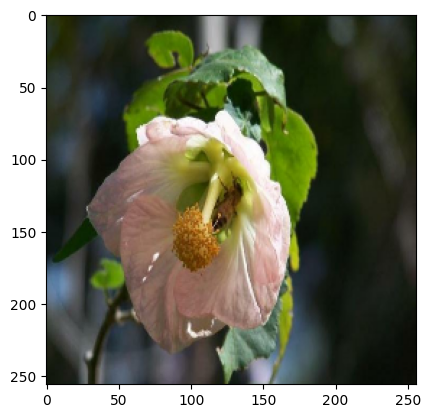

In [21]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(np.argmax(batch_prediction[0]))
    print([f"{value * 100:.6f}%" for value in batch_prediction[0]])
    print(class_names)

Just shows an example of an inputted image going in, getting predicted and then being displayed

In [12]:
model.save(f"models/model 2 full")

INFO:tensorflow:Assets written to: models/model 2 full\assets


INFO:tensorflow:Assets written to: models/model 2 full\assets


In [14]:
loaded_model = tf.keras.models.load_model('models/model 2 full')

In [29]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)       

In [6]:
modified_105_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "training data/oxford 102 flowers",
    shuffle=True,
    color_mode='rgb',
    labels='inferred',
    image_size=(256,256),
    batch_size = 32
)
dataset_class_names = modified_105_ds.class_names


Found 7957 files belonging to 100 classes.


In [47]:
loaded_model.evaluate(modified_105_ds)

279/279 [==============================] - 95s 337ms/step - loss: 0.5957 - accuracy: 0.8597


[0.5956718921661377, 0.85965895652771]

In [73]:
tally = 0
total = 0
for images_batch, labels_batch in modified_105_ds.take(1000):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    batch_prediction = model.predict(images_batch)
    classified_indexes = heapq.nlargest(3, range(len(batch_prediction[0])), key=batch_prediction[0].__getitem__)
    act_label = dataset_class_names[first_label]
    predict_label = class_names[classified_indexes[0]]
    # predict_label_2 = class_names[classified_indexes[1]]
    # predict_label_3 = class_names[classified_indexes[2]]
    # print(act_label + "    " + predict_label + "    " + predict_label_2 + "    " + predict_label_3)
    print(act_label + "    " + predict_label)
    
    total += 1
    # if (act_label == predict_label) | (act_label == predict_label_2) | (act_label == predict_label_3) :
    if act_label == predict_label :
        tally += 1
print("Oxford 102 dataset test, top answer only")
print("accuracy : " + str(tally / total))

1/1 [==============================] - 0s 341ms/step
petunia    petunia
1/1 [==============================] - 0s 336ms/step
petunia    petunia
1/1 [==============================] - 0s 335ms/step
giant white arum lily    giant white arum lily
1/1 [==============================] - 0s 334ms/step
moon orchid    moon orchid
1/1 [==============================] - 0s 442ms/step
bishop of llandaff    bishop of llandaff
1/1 [==============================] - 0s 377ms/step
californian poppy    californian poppy
1/1 [==============================] - 0s 345ms/step
wallflower    wallflower
1/1 [==============================] - 0s 348ms/step
blackberry lily    blackberry lily
1/1 [==============================] - 0s 325ms/step
camellia    camellia
1/1 [==============================] - 0s 336ms/step
morning glory    morning glory
1/1 [==============================] - 0s 330ms/step
magnolia    magnolia
1/1 [==============================] - 0s 326ms/step
frangipani    frangipani
1/1 [=========

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


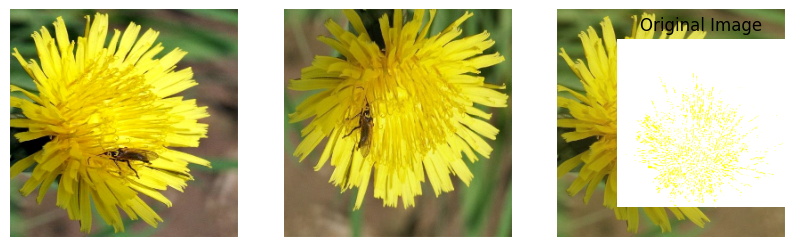

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

def manual_data_augmentation(image):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random rotation (up to 20%)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Rescale to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image

def display_augmented_images(image, num_instances=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_instances):
        augmented_image = manual_data_augmentation(image)
        plt.subplot(1, num_instances, i+1)
        plt.imshow(augmented_image.numpy())
        plt.axis('off')
    plt.subplot(1, num_instances+1, num_instances+1)  # Corrected the subplot index
    plt.imshow(image.numpy())
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

# Example usage:
for images_batch, labels_batch in modified_105_ds.take(1):
    display_augmented_images(images_batch[0])
